**AUTHORS:** \\
Bennett Bierman \\
Filippo Nardi \\
Jorge Parreño \\
Jaime Martinez \\
Robert Glazer

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
from os import listdir
import pandas as pd

In [ ]:
%cd '/content/gdrive/MyDrive/Machine learning II/Discrete Lab'
data = pd.read_csv('penalty_dataset.csv')

In [ ]:
# for Filippo
%cd '/content/gdrive/MyDrive/ML2/discrete bla bla'
data = pd.read_csv('penalty_dataset.csv')

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import beta
from numpy.random import multinomial
from scipy.stats import dirichlet
import matplotlib.tri as tri
from scipy.special import softmax
from matplotlib.lines import Line2D

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [ ]:
from IPython.core.display import Image, display

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


## Degree in Data Science and Engineering, group 96
## Machine Learning 2
### Fall 2020

&nbsp;
&nbsp;
&nbsp;
# Lab 4. Unsupervised Learning: Discrete Data

&nbsp;
&nbsp;
&nbsp;

**Ignacio Peis**

Dept. of Signal Processing and Communications

&nbsp;
&nbsp;
&nbsp;




<img src='https://www.uc3m.es/ss/Satellite?blobcol=urldata&blobkey=id&blobtable=MungoBlobs&blobwhere=1371573953235&ssbinary=true' width=400 />


# Introduction
In this lab session you will study two probabilistic models for discrete data. First, in Section 1, you will use a Beta-Binomial model for learning the probability of binary data from observations of penalty kicks in the Premier League. Second, in Section 2, you will employ a Dirichlet-Multinomial model for learning the probability that a musical genre appears on a spotify top list. For both cases, we apply simple Bayesian models.

## A few notes on Bayesian modeling

During this notebook, we employ basic probabilistic notation for priors, likelihoods and posteriors. The expression $p(x | y)$ denotes a probability distribution (a mathematical function over the probability for each possible value of $x$) of variable $x$, once $y$ is given. Employing easy terms, we could say that $p(x | y)$ is a function over $x$ that includes a known 'parameter' $y$ inside. In Bayesian world, we use this notation when the probability of a variable $x$ depends on the value of other variable $y$. What if knowing $p(x|y)$, we want to obtain $p(y|x)$? We can use the **Bayes theorem**:
\begin{equation}
p(y|x) = \frac{p(x|y) p(y)}{p(x)}
\end{equation}
We are interested in finding the posterior distribution of a variable. The procedure is always the same:
- First, we assume a model where some parameter $ \theta$ has a rol in the generation of data.
- Second, we define a **prior** distribution over the parameter of interest, $p(\theta)$, that captures our a priori assumptions about how $\theta$ might be distributed, and a **likelihood** distribution, $p(\mathcal{D} | \theta)$, that measures how probable are your observations given a value of $\theta$.
- Third, we compute the **posterior** $p(\theta | \mathcal{D})$ using Bayes theorem. The posterior distribution incorporates knowledge from observed data and gives you a distribution of the parameters, given the **evidence** you have observed in $\mathcal{D}$.
\begin{equation}
p(\theta|\mathcal{D}) = \frac{p(\mathcal{D}|\theta) p(\theta)}{p(\mathcal{D})}
\end{equation}
The denominator is a normalization constant called *evidence*. As it is constant, we will ignore it to compute the posterior distribution, using:
\begin{equation}
p(\theta|\mathcal{D}) \propto p(\mathcal{D}|\theta) p(\theta)
\end{equation}
The posterior distribution will give you the values of $\theta$ that are more probable, given your dataset. Different approaches can be employed to obtain an estimation for the parameter of interest $\hat{\theta}$.


# 1. Binary data
In this first section we use a model for binary data. The parameter $\theta$ is the probability of $1$ (success). Given this parameter, we can express how probable are the observations via the likelihood. For this section, we are going to model the probability of scoring a goal in penalty kicks.


## 1.1. Dataset
The dataset $\mathcal{D}$ is composed by $N=106$ binary $D$-dimensional observations, in the form:

$\textbf{x}_i = [x_1, ..., x_D] \qquad$ with $x_i \in \{0, 1\}  \qquad \mathcal{D}= \{ \textbf{x}_1, ..., \textbf{x}_N \} \qquad$

We use the following <a href="https://www.kaggle.com/mauryashubham/english-premier-league-penalty-dataset-201617">dataset</a> that contains a register of penalty kicks in Premier League for season 2016/2017. Data is formatted in the csv file <code>penalty_data.csv</code>, and we are going to model variables $x_1$: <code>Scored</code>, $x_2$: <code>Foot</code>, $x_3$: <code>Kick_Direction</code>, $x_4$: <code>Keeper_Direction</code> and $x_5$: <code>Half</code>, for some value of <code>Team</code> and <code>Player</code>. For variable  <code>Scored</code>, $0 \equiv miss$ and $1 \equiv goal$. For variables <code>Foot</code>, <code>Kick_Direction</code> and <code>Keeper_Direction</code>, $0 \equiv left$ and $1 \equiv right$. For variable <code>Half</code>, $0 \equiv first$ and $1 \equiv second$. An example of how to obtain a matrix $\textbf{X}$ with all the observations for team "Man City" and player "Harry Kane" during the season is included below. We employ framework <a href="https://pandas.pydata.org/docs/reference/index.html#api">pandas</a> for reading the dataset.



In [ ]:
# If you run locally, set use_colab=False
use_colab=False

if use_colab==True:
    # To work in colab
    from google.colab import files
    uploaded = files.upload()
    import io
    data = pd.read_csv(io.BytesIO(uploaded['penalty_dataset.csv']))

else:
    data = pd.read_csv('penalty_dataset.csv')


In [ ]:
N = len(data)
variables = ['Scored', 'Foot', 'Kick_Direction', 'Keeper_Direction', 'Half']
D = len(variables)
data.head()


,No.,Match Week,Date,Player,Team,Match,Half,Scored,Final Results,Foot,Kick_Direction,Keeper_Direction,Saved
0,1,1,13-Aug-16,Riyad Mahrez,Leicester,Hull vs Leicester,1,1,42737,0,0,1,NaN
1,2,1,13-Aug-16,Sergio Agüero,Man City,Man City vs Sunderland,0,1,42737,1,0,0,NaN
2,3,1,14-Aug-16,Theo Walcott,Arsenal,Arsenal vs Liverpool,0,0,42828,1,0,0,1.0
3,4,1,15-Aug-16,Eden Hazard,Chelsea,Chelsea vs West Ham,1,1,42737,1,0,0,NaN
4,5,2,19-Aug-16,Zlatan Ibrahimovic,Man United,Man United vs Southampton,1,1,2-0,1,0,1,NaN


In [ ]:
def filter_data(data, key="all", value=""):
    if key=='all':
        X=np.array(data[variables]).astype(int)
    else:
        filtered = data[data[key]==value][variables]
        X = np.array(filtered).astype(int)
    return X

# Penalties for Man City
X = filter_data(data, 'Team', 'Man City')
print("Penalty kicks for Man City: ")
print(str(X))

# Penalties for Harry Kane
X = filter_data(data, 'Player', 'Harry Kane')
print("Penalty kicks for Harry Kane: ")
print(str(X))

# All the penalties
X = filter_data(data, 'all')


Penalty kicks for Man City: 
[[1 1 0 0 0]
 [1 1 0 1 0]
 [1 1 0 1 1]
 [0 1 1 1 0]
 [0 1 0 0 1]
 [1 1 0 1 1]
 [1 1 0 0 1]
 [1 1 0 1 1]
 [1 1 0 1 0]]
Penalty kicks for Harry Kane: 
[[1 1 1 1 1]
 [1 1 0 0 1]
 [1 1 0 1 0]
 [0 1 0 1 1]
 [1 1 1 0 1]
 [1 1 0 0 1]]


## 1.2. Model

### 1.2.1. Likelihood
The likelihood models how probable is the data given a value of the parameters. The **Bernouilli distribution** distribution, parametrized by $\theta$, models the probability of success in a binary-outcome experiment. This distribution will model each dimension inside each observation. As we assume independent dimensions, the probabilities per dimension are multiplied:

\begin{equation}
p(\mathcal{D} | \theta) = \prod_{i=1}^N \prod_{k=1}^D \text{Ber} (x_{id}| \theta_d) = \prod_{i=1}^N \prod_{i=1}^D \theta_d^{\mathbb{I}(x_{id}=1)} (1-\theta_d)^{\mathbb{I}(x_{id}=0)}
\end{equation}

#### Sufficient Statistics
To make life easier, we use the sufficient statistics of $\mathcal{D}$. Instead of evaluating whether each variable is scored, we sum the number of successes ($1$) and failures ($0$) in $N$ kicks and use $N_1 = \sum_{i=1}^N \mathbb{I}(x_i=1)$ and $N_0 = \sum_{i=1}^N \mathbb{I}(x_i=0)$. We call $\phi(\mathcal{D})$ sufficient statistics for parameter $\theta$ from $\mathcal{D}$ if $p(\theta | \mathcal{D}) = p(\theta | \phi(\mathcal{D})) $. From this perspective, we use the **Binomial distribution**, which models the number of successes $N_1$ in a total of $N$ trials.
Thus, our equivalent likelihood is:

\begin{equation}
p(\mathcal{D} | \theta) \equiv \prod_{d=1}^{D} p(N_{1d} | \theta_d) = \prod_{d=1}^{D} \text{Bin}(N_{1d}|N, \theta) =
\prod_{d=1}^{D}
\begin{pmatrix}
N  \\ N_{1d}
\end{pmatrix}
\theta^{N_{1d}}(1-\theta_d)^{N_{0d}}
\end{equation}

### 1.2.2. Prior
The prior models the information we know *a priori* about how the parameters are distributed. It will influence the learned posterior. The **Beta distribution** models the probability of a variable with range between $0$ and $1$. Two parameters, $a$ and $b$, control the shape of the distribution:

\begin{equation}
p(\theta) = \text{Beta}(\theta|a, b) = \frac{1}{B(a, b)} \theta^{a-1} (1-\theta)^{b-1}
\end{equation}
where $B(a, b) = \frac{\Gamma(a)\Gamma(b)}{\Gamma(a+b)}$ and $\Gamma(\cdot)$ is the Gamma function.

When $a=b$ the function is symmetric. If $a=b>1$ the probability mass will be closer to the center ($\theta=0.5$), while if $a=b<1$ the probability mass will be more concentrated in the corners. If $a=b=1$, the probability is uniform, and all the values of $\theta$ are equiprobable. We will denote this configuration as *flat prior*. Using different values for $a$ and $b$ we can control the assymetry and assign more or less to prabability to each class.

In this case, as we have binary vectors, we are defining a different prior for each $\theta_d$, and thus, parameters $a_d$ and $b_d$ need to be defined for each dimension:
\begin{equation}
p(\boldsymbol{\theta}) = \prod_{d=1}^{D} \text{Beta}(\theta_d|a_d, b_d)
\end{equation}

For example, for variable <code>Scored</code> ($d=1$), we expect that probability of goal is higher than miss. Thus, we might choose a value of $a$ higher than $b$. Nevertheless, for the variable <code>Half</code> ($d=5$) (half of the match where the penalty was kicked), we do not know a priori which half is more probable, so $a=b=1$ (flat prior) is adecquate for this dimension.

*Note: Beta probability function can be used in this notebook. Use <code>beta.pdf(theta, a, b)</code> to compute the probability of <code>theta</code> with parameters $a$ and $b$.*



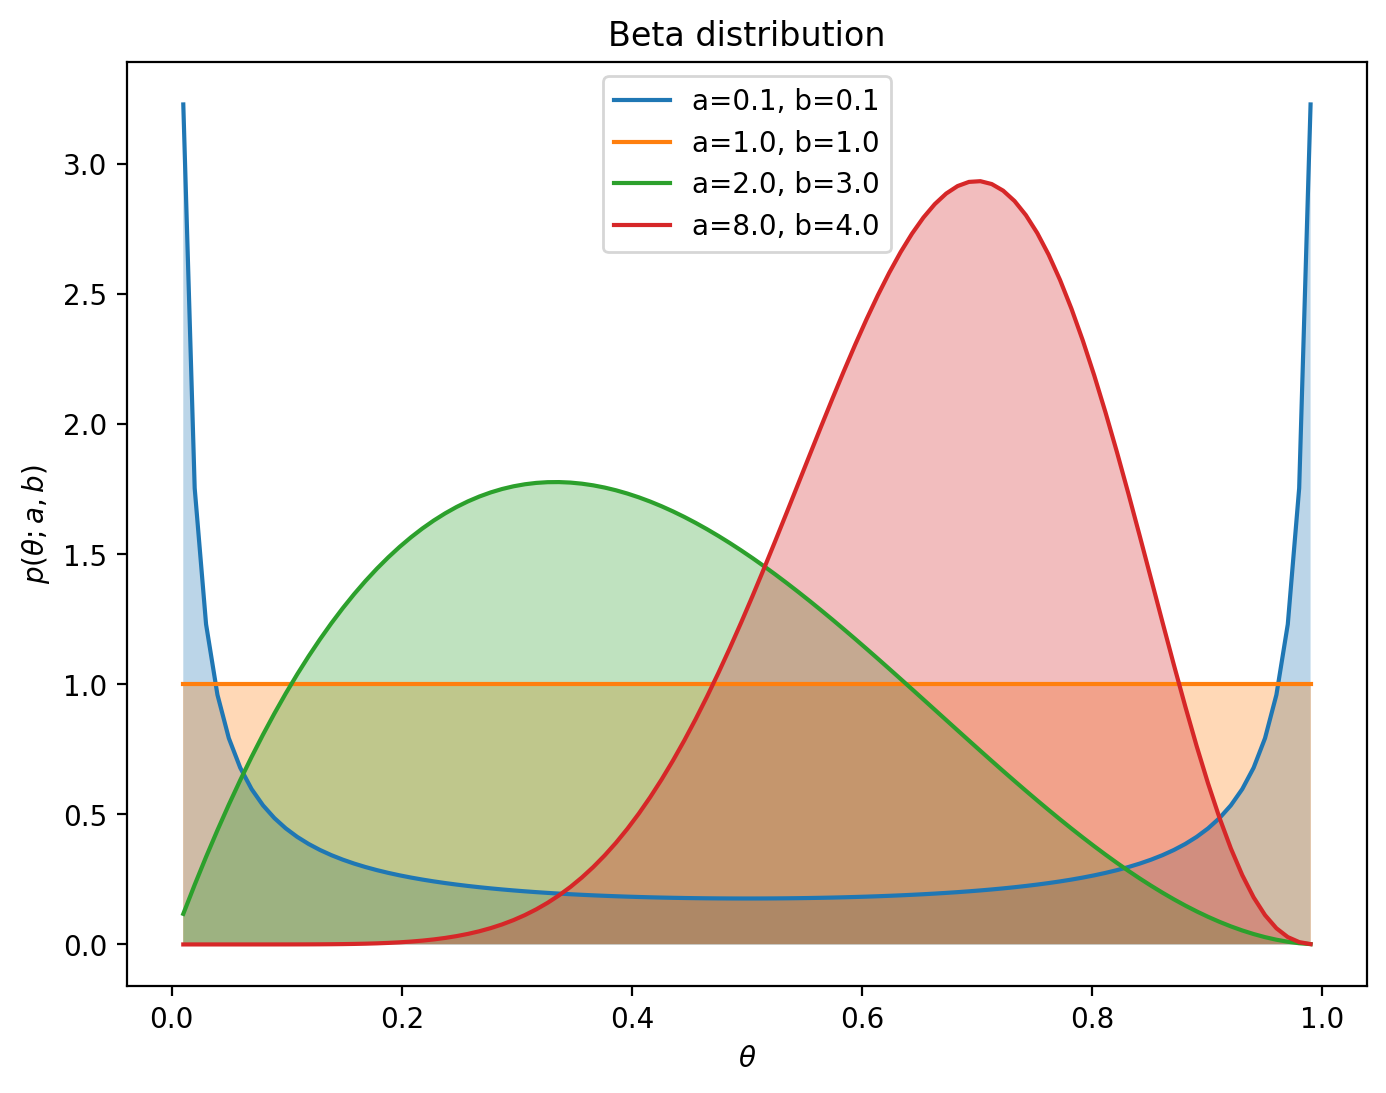

In [ ]:

# Visualizing the beta distribution
a_list = [0.1, 1.0, 2.0, 8.0]        # 4 possible values of a
b_list = [0.1, 1.0, 3.0, 4.0]        # 4 possible values of b
x_domain = np.linspace(0.01, 0.99, 100)    # 100 points beween 0 and 1
plt.figure(figsize=(8, 6))

for a, b in zip(a_list, b_list):
    p = beta.pdf(x_domain, a, b)
    plt.plot(x_domain, p, label='a=' + str(a) + ', b=' + str(b))
    plt.fill_between(x_domain, 0, p, alpha=0.3 )

plt.legend(loc='best')
plt.xlabel(r'$\theta$')
plt.ylabel(r'$ p(\theta; a, b) $')
ttl=plt.title('Beta distribution')


As you can see above, the uniform distribution over $[0, 1]$ is obtained when $a=b=1$ (orange line). With the red distribution we model a parameter that generates more goals than misses. The green one express the contrary, we expect more misses than goals. The width of the distributions gives us an idea of how much the probability mass is concentrated around the maximum.

### 1.2.3. Posterior
The posterior distribution can be obtained from the prior and likelihood, using Bayes Rule:

\begin{gather}
\begin{matrix}
    p(\boldsymbol{\theta} | \mathcal{D}) &  \propto  & p(\mathcal{D} | \boldsymbol{\theta}) p(\boldsymbol{\theta}) \\
    & \propto & \prod_{d=1}^{D} \theta_d^{N_{1d}}(1-\theta_d)^{N_{0d}} \theta_d^{a_d-1} (1-\theta_d)^{b_d-1} \\
    & \propto & \prod_{d=1}^{D} \theta_d^{N_{1d}+a_d-1} (1-\theta_d)^{N_{0d}+b_d-1} \\
    & = & \prod_{d=1}^{D} \text{Beta}(N_{1d}+a_d, N_{0d}+b_d)
\end{matrix}
\end{gather}
The posterior of $\theta$, given the sufficient statistics from the observations in $\mathcal{D}$ and defining the prior as a Beta on each dimension, is another product of Beta distributions with parameters $N_{1d}+a_d$ and $N_{0d} +b_d$ on each dimension. The fact that the posterior has the same functional form than the prior (same type of distribution) is called **conjugacy**.

### 1.2.4. Estimation
Once the model is fitted, we can make estimations of the value of $\theta$. As we assume independent dimension, from the posterior distribution $p(\boldsymbol{\theta} | \mathcal{D})=\prod_{d=1}^{D}p(\theta_d | \mathcal{D})$ we can obtain each $\hat{\theta_d}$ using different criteria:
- **Maximum A Posteriori (MAP)**: the estimate is the mode of the posterior $p(\theta_d | \mathcal{D})$.
   
\begin{equation}
    \hat{\theta}_d^{MAP} = \underset{x}{\text{argmax}} p(\theta_d | \mathcal{D}) = \frac{N_{1d}+a_d-1}{N+a_d+b_d-2}
\end{equation}
You can observe that $a_d$ are $b_d$ (user-defined for the prior) influence the posterior results.

- **Maximum Likelihood (ML)**: the estimate is the mode of the likelihood $p( \mathcal{D} | \theta_d)$.
   
\begin{equation}
    \hat{\theta}_d^{ML} = \underset{x}{\text{argmax}} p( \mathcal{D} | \theta) = \frac{N_{1d}}{N}
\end{equation}

- **Mean**: the estimate is the mean of the posterior:
\begin{equation}
    \hat{\theta}_d^{mean} = \bar{\theta_d} = \frac{N_{1d}+a_d}{N+a_d+b_d}
\end{equation}

The variance of the posterior distribution gives us a measure of the variability of the probability of success. The higher the variance, the more uncertainty we have about :
\begin{equation}
    \text{Var}(\theta_d | \mathcal{D}) = \frac{(N_{1d}+a_d)(N_{0d}+b_d)}{(N+a_d+b_d)^2(N+a_d+b_d+1)} \approx \frac{\bar{\theta_d} (1-\bar{\theta_d})}{N}
\end{equation}

Another important distribution is the **posterior predictive** that gives the probability of a new trial, given all the experience:
\begin{gather}
\begin{matrix}
p(x_d=1|\mathcal{D}) & = & \int_0^1  p(x_d=1 | \theta_d) p(\theta_d | \mathcal{D}) d \theta_d \\
& = & \int_0^1 \theta_d \text{Beta}(N_{1d}+a_d, N_{0d}+b_d) d\theta_d \\
& = & \mathbb{E} \{ \theta_d | \mathcal{D} \} = \bar{\theta_d} = \frac{N_{1d}+a_d}{N+a_d+b_d}
\end{matrix}
\end{gather}


## 1.3. Experiments

### 1.3.1. Sufficient statistics

**Calculate the sufficient statistics $\textbf{N}_1=[N_{01}, ..., N_{05}]$ and $\textbf{N}_0=[N_{11}, ..., N_{15}]$  of the dataset $\mathcal{D}$.**

In [ ]:
#############
#           #
# YOUR CODE #
#           #
#############

N_1 = np.sum(X, axis=0)
N_0 = X.shape[0] - N_1

print(f'N1: {N_1}')
print(f'N0: {N_0}')

N1: [81 85 39 52 64]
N0: [25 21 67 54 42]


### 1.3.2. Computing the posterior distribution

**Compute the parameters $\textbf{a}_{post}$ and $\textbf{b}_{post}$ of the posterior distribution $p(\boldsymbol{\theta} | \mathcal{D})$, once defined the prior with $\textbf{a}$ and $\textbf{b}$, using the given expressions. Use a flat prior ($a_d=b_d=1$) for every dimension. Show in the same plot $p(\theta_d | \mathcal{D})$ for $d={1, ..., 5}$.**


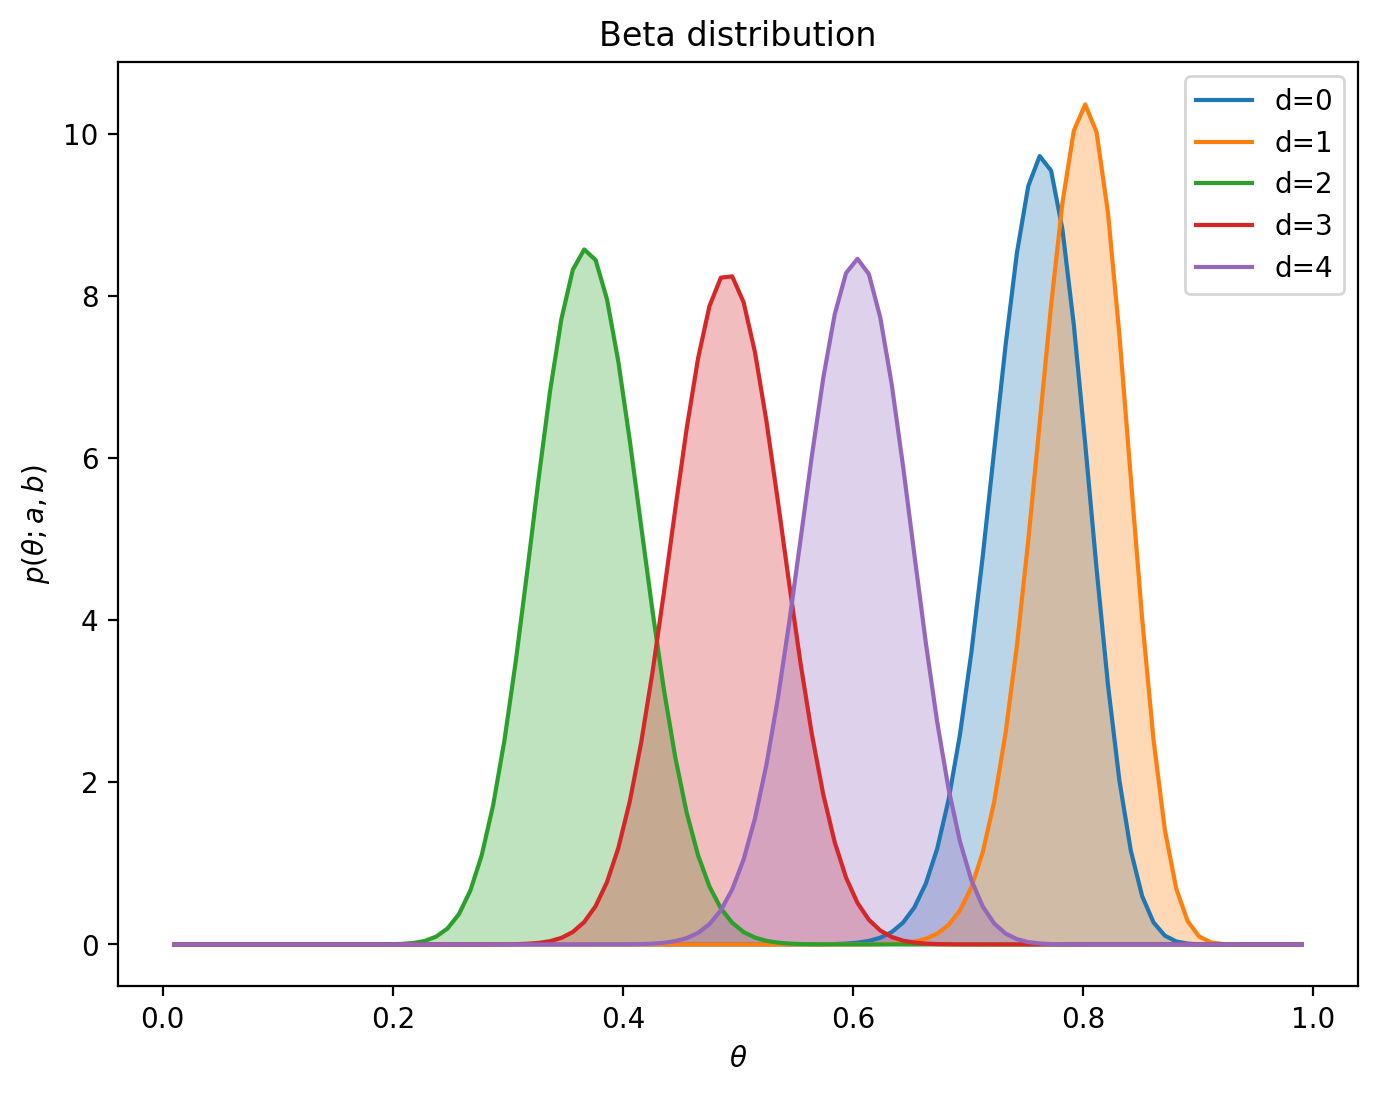

In [ ]:
#############
#           #
# YOUR CODE #
#           #
#############

a = b = np.ones(X.shape[1])
a_post = a + N_1
b_post = b + N_0

plt.figure(figsize=(8, 6))

for d in range(X.shape[1]):
  post = beta.pdf(x_domain, a_post[d], b_post[d])
  plt.plot(x_domain, post, label='d=' + str(d))
  plt.fill_between(x_domain, 0, post, alpha=0.3 )

plt.legend(loc='best')
plt.xlabel(r'$\theta$')
plt.ylabel(r'$ p(\theta; a, b) $')
ttl=plt.title('Beta distribution')

### 1.3.3 Influence of the dataset size
In this section you will evaluate and study the estimation results when varying the dataset size by filtering for different Players and Teams.

**1. Obtain and compare in the same plot the posterior distribution of scoring a goal $p(\theta_0 | \mathcal{D})$ for each player in the given list. Include the prior in the same plot (use flat prior, $a=b=1$).**

**2. Obtain and compare in the same plot the posterior distribution of the kick direction $p(\theta_3 | \mathcal{D})$ for each player in the given list. Include the prior in the same plot (use flat prior, $a=b=1$). In this case, include also the posterior for the entire dataset.**

**3. Obtain and compare in the same plot the posterior distribution of scoring a goal for each team in the given list. Include the prior in the same plot (use flat prior, $a=b=1$).**


In [ ]:
# Helper function to help answer all questions
# in this section

def show_post(d, item_list, category, d_cat='', add_prior=True, total_post=False):

  plt.figure(figsize=(8, 6))
  x_domain = np.linspace(0.01, 0.99, 100)
  alpha = 0.1
  N_1_total, N_0_total = 0, 0

  for item in item_list:
    X_item = filter_data(data, category, item)
    N_1 = np.sum(X_item[:, d], axis=0)
    N_0 = X_item.shape[0] - N_1

    if total_post:
      N_1_total += N_1
      N_0_total += N_0

    a_post, b_post = 1 + N_1, 1 + N_0
    post = beta.pdf(x_domain, a_post, b_post)
    plt.plot(x_domain, post, label=str(item))
    plt.fill_between(x_domain, 0, post, alpha=alpha )

  if add_prior:
    p = beta.pdf(x_domain, 1, 1)
    plt.plot(x_domain, p, label='Flat Prior')
    plt.fill_between(x_domain, 0, p, alpha=alpha)

  # Calculate entire posterior
  if total_post:
    a_post = N_1_total + 1
    b_post = N_0_total + 1
    post = beta.pdf(x_domain, a_post, b_post)
    plt.plot(x_domain, post, label='Total Posterior')
    plt.fill_between(x_domain, 0, post, alpha=alpha )

  plt.legend(loc='best')
  plt.xlabel(r'$\theta$')
  plt.ylabel(r'$ p(\theta; a, b) $')

  if d_cat == '':
    ttl=plt.title(f'Beta distribution by {category}' )
  else:
    ttl=plt.title(f'Beta distribution of {d_cat} by {category}')

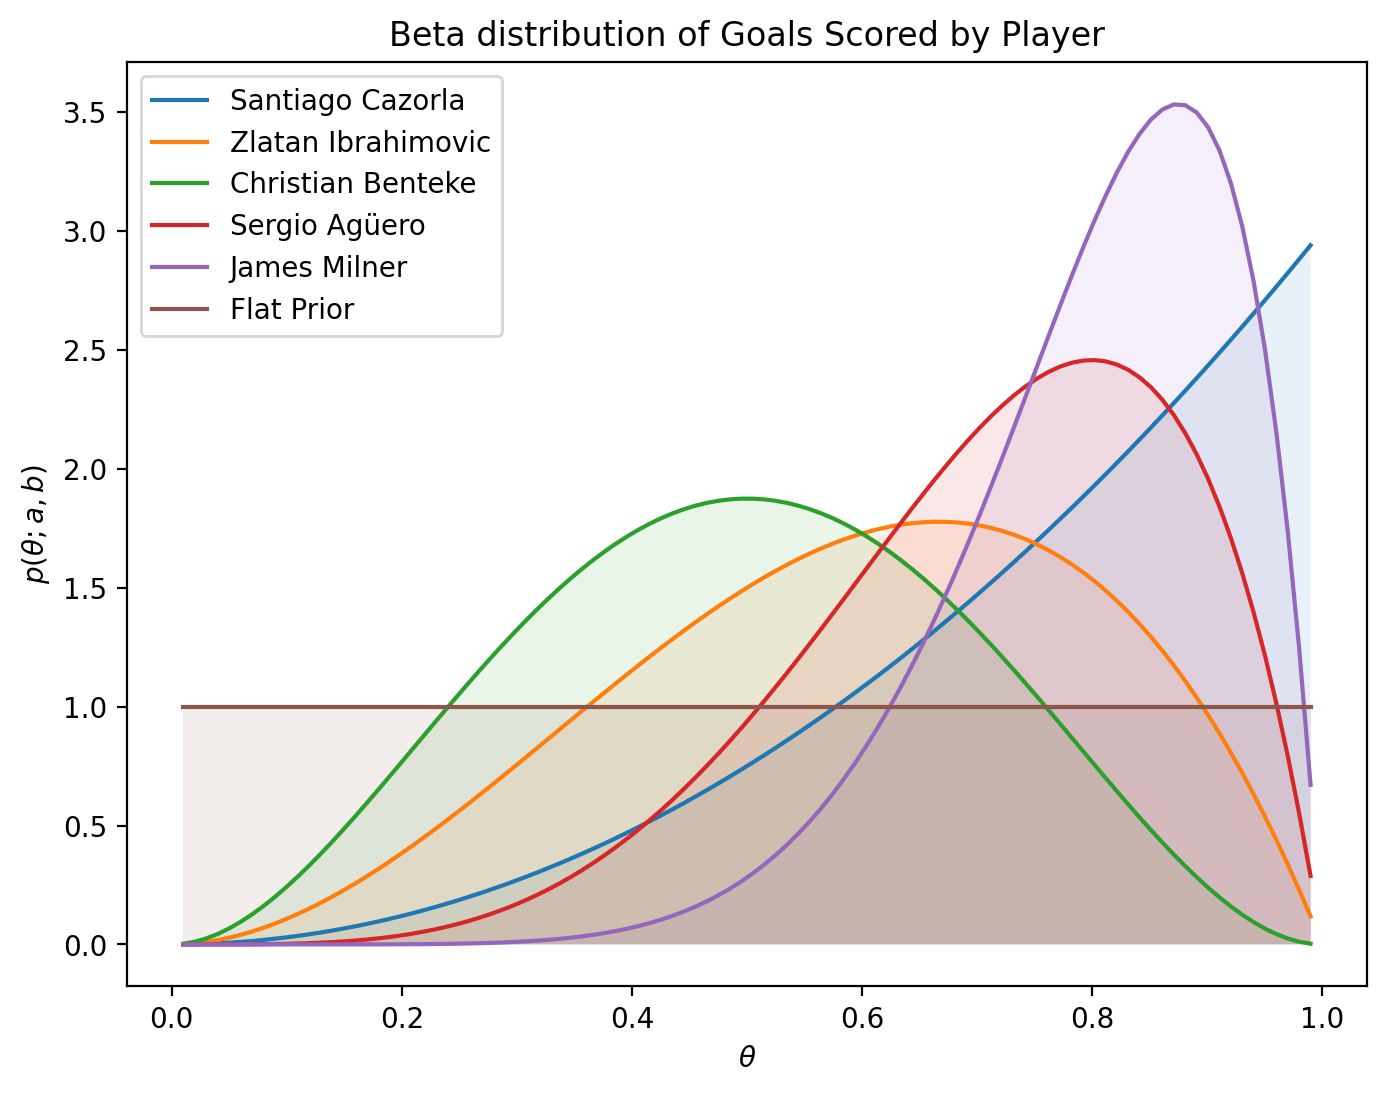

In [ ]:
players = ['Santiago Cazorla', 'Zlatan Ibrahimovic', 'Christian Benteke', 'Sergio Agüero', 'James Milner']
teams = ['West Brom', 'Middlesbrough', 'Watford', 'Man United', 'West Ham', 'Arsenal', 'Crystal Palace', 'Liverpool', 'Man City']

##########################
#         PLAYERS        #
##########################

# x0: SCORED
d=0

#############
#           #
# YOUR CODE #
#           #
#############

show_post(d, players, 'Player', d_cat='Goals Scored')

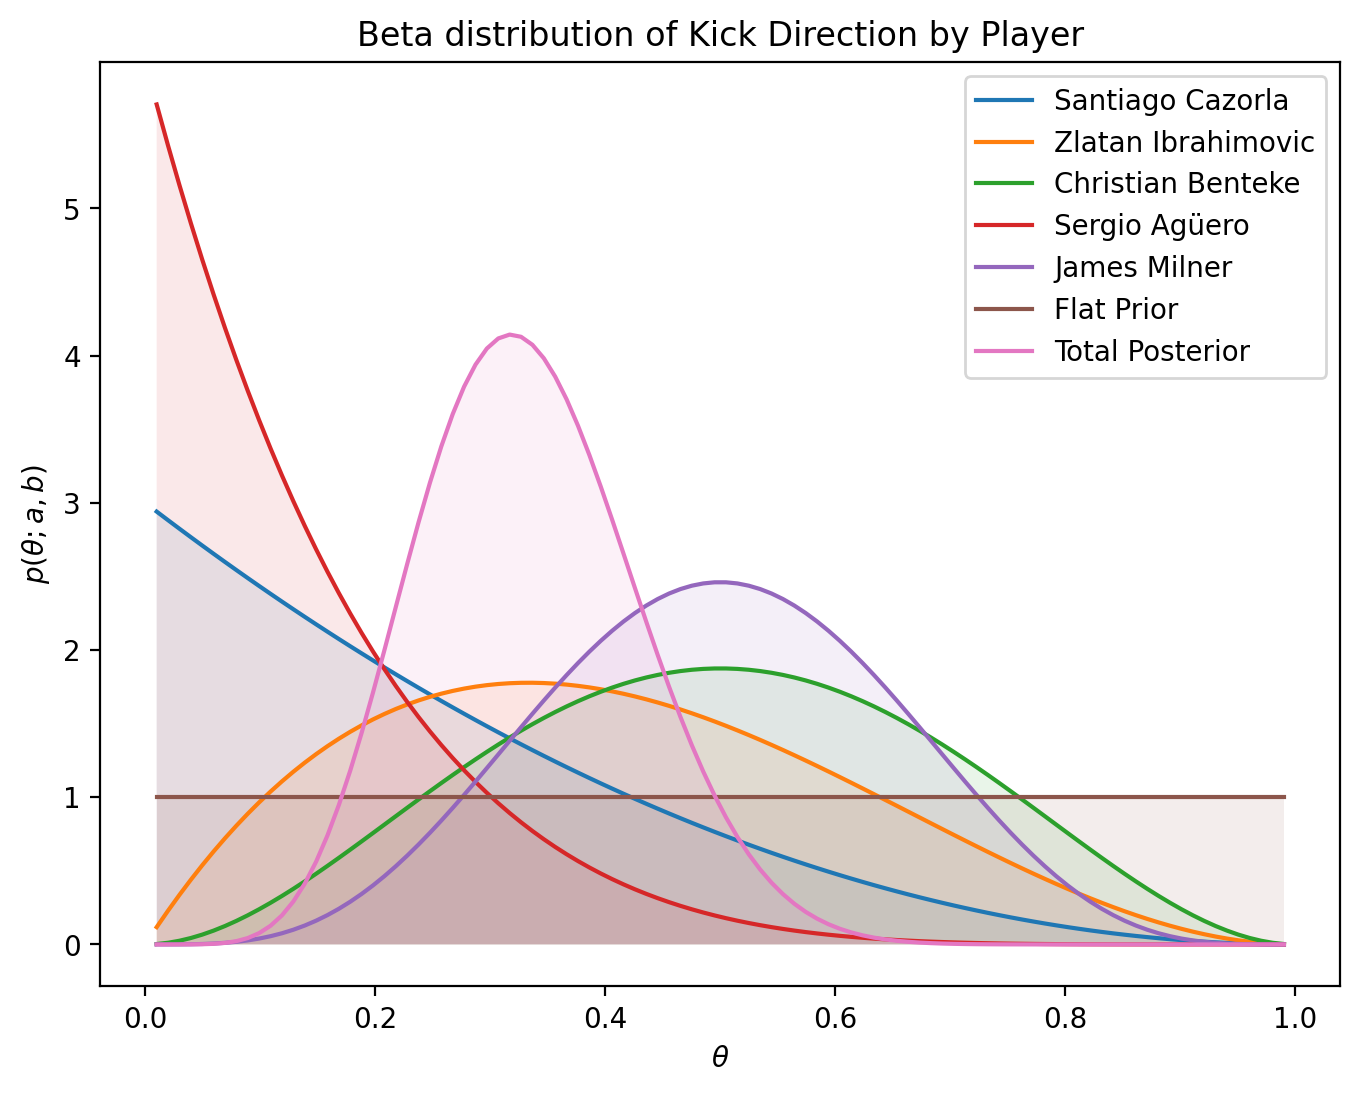

In [ ]:
# x2: KICK_DIRECTION
d=2

#############
#           #
# YOUR CODE #
#           #
#############

show_post(d, players, 'Player', d_cat='Kick Direction', total_post=True)

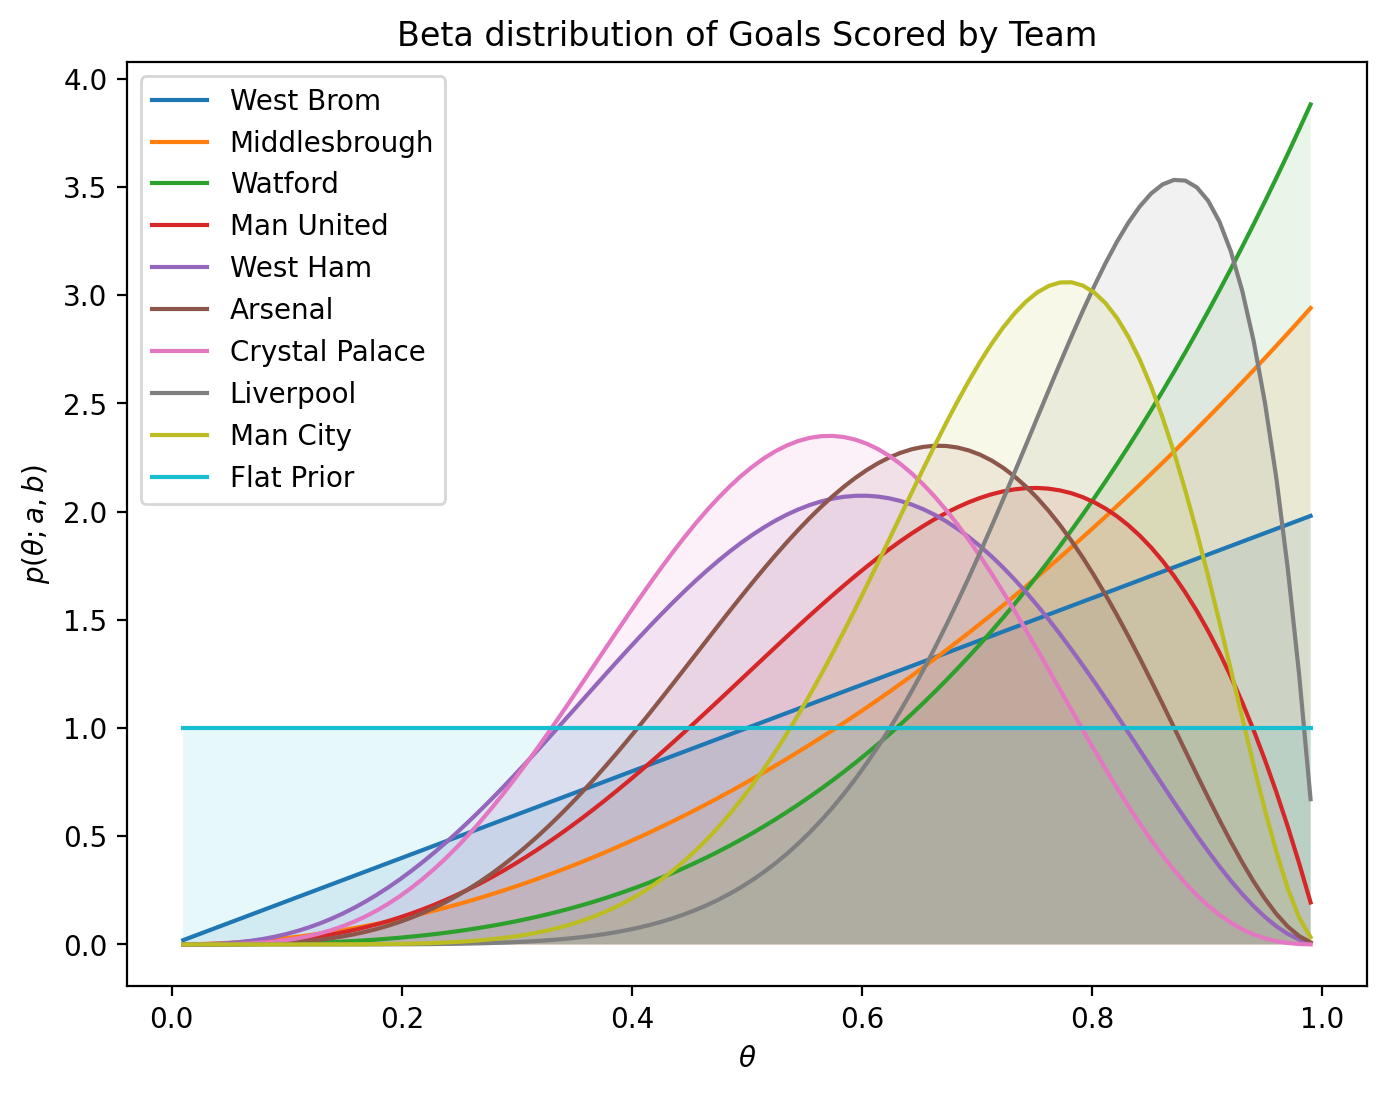

In [ ]:
##########################
#          TEAMS         #
##########################
# x0: SCORED
d=0

#############
#           #
# YOUR CODE #
#           #
#############

show_post(d, teams, 'Team', d_cat='Goals Scored')


# COMPROBAR

### Questions
**Give a answer of the following questions, based on the analysis of the plots you have obtained:**

**1. Which differences do you notice among the obtained posterior distributions of scoring a goal and kick direction for different players? *Pay attention to the number of observations for each player*.**

- In the kick direction the proability mass is more evenly distributed for the different values of $\theta$ compared to the goal scoring, which makes sense since there is more variability in different kicking directions and this is reflected in the wider distribution of the probability mass of $\theta$ and in the posterior.

**2. Who would you say is the most effective for kicking penalties?.**

- James Milner is the player for which the highest peak of the posterior for goals scored is found.


### 1.3.4. Influence of the prior
In this section you will study the influence of the prior in the posterior computation.

**1. Obtain and compare in the same plot the posterior distribution of the kick direction $p(\theta_3 | \mathcal{D})$ for left and right-footed players. Using different linestyles, include the results when using three priors: flat prior, fair prior ($a_d=5, b_d=5$) and uninformative prior ($a_d=b_d=0.5$).**

**2. Obtain the MAP estimations for the probability of kicking to the right in a penalty, for left and right-footed players, using flat prior.**

**3. Obtain the posterior of scoring a goal for player Harry Kane.  Compare in the same plot the posterior for the three mentioned priors. In this case, obtain the MAP and ML estimations for each prior.**





In [ ]:
def MAP_est(X, a, b):
    """MAP estimation of theta, given observations X and prior parameters a and b"""
    #############
    #           #
    # YOUR CODE #
    #           #
    #############
    N1, N = sum(X), len(X)
    theta = (N1 + a - 1)/(N + a + b - 2)
    return theta

def ML_est(X, a, b):
    """ML estimation of theta, given observations X and prior parameters a and b"""
    #############
    #           #
    # YOUR CODE #
    #           #
    #############
    N1, N = sum(X), len(X)
    theta = N1/N
    return theta


In [ ]:
# passing array of as and array of bs

def showPost(d, item_list, category, a_values, b_values, d_cat='', add_prior=True, total_post=False):
    plt.figure(figsize=(8, 6))
    x_domain = np.linspace(0.01, 0.99, 100)
    alpha = 0.1
    N_1_total, N_0_total = 0, 0

    for item in item_list:
        X_item = filter_data(data, category, item)
        N_1 = np.sum(X_item[:, d], axis=0)
        N_0 = X_item.shape[0] - N_1

        if total_post:
            N_1_total += N_1
            N_0_total += N_0

        for a, b in zip(a_values, b_values):
            a_post, b_post = a + N_1, b + N_0
            post = beta.pdf(x_domain, a_post, b_post)
            plt.plot(x_domain, post, label=f'{item} (a={a}, b={b})')
            plt.fill_between(x_domain, 0, post, alpha=alpha)

    if add_prior:
        p = beta.pdf(x_domain, 1, 1)
        plt.plot(x_domain, p, label='Flat Prior')
        plt.fill_between(x_domain, 0, p, alpha=alpha)

    # Calculate entire posterior
    if total_post:
        a_post = N_1_total + 1
        b_post = N_0_total + 1
        post = beta.pdf(x_domain, a_post, b_post)
        plt.plot(x_domain, post, label='Total Posterior')
        plt.fill_between(x_domain, 0, post, alpha=alpha)

    plt.legend(loc='best')
    plt.xlabel(r'$\theta$')
    plt.ylabel(r'$p(\theta; a, b)$')

    if d_cat == '':
        title = f'Beta distribution by {category}'
    else:
        title = f'Beta distribution of {d_cat} by {category}'
    plt.title(title)


In [ ]:
# passing arrays of as, bs and no filtering
def showPostnoFilter(X_item,d, category, a_values, b_values, c_cat='', d_cat='', add_prior=True, total_post=False):
    plt.figure(figsize=(8, 6))
    x_domain = np.linspace(0.01, 0.99, 100)
    alpha = 0.1
    N_1_total, N_0_total = 0, 0
    N_1 = np.sum(X_item[:, d], axis=0)
    N_0 = X_item.shape[0] - N_1

    if total_post:
       N_1_total += N_1
       N_0_total += N_0

    for a, b in zip(a_values, b_values):
       a_post, b_post = a + N_1, b + N_0
       post = beta.pdf(x_domain, a_post, b_post)
       plt.plot(x_domain, post, label=f'{c_cat} (a={a}, b={b})')
       plt.fill_between(x_domain, 0, post, alpha=alpha)

    if add_prior:
        p = beta.pdf(x_domain, 1, 1)
        plt.plot(x_domain, p, label='Flat Prior')
        plt.fill_between(x_domain, 0, p, alpha=alpha)

    # Calculate entire posterior
    if total_post:
        a_post = N_1_total + a
        b_post = N_0_total + b
        post = beta.pdf(x_domain, a_post, b_post)
        plt.plot(x_domain, post, label='Total Posterior')
        plt.fill_between(x_domain, 0, post, alpha=alpha)

    plt.legend(loc='best')
    plt.xlabel(r'$\theta$')
    plt.ylabel(r'$p(\theta; a, b)$')

    if d_cat == '':
        title = f'Beta distribution by {category}'
    else:
        title = f'Beta distribution of {d_cat} by {category}'
    plt.title(title)

1.3.4.1

In [ ]:
# 1.3.4.1a
righty = filter_data(data, 'Foot', 1)
lefty = filter_data(data,'Foot', 0)

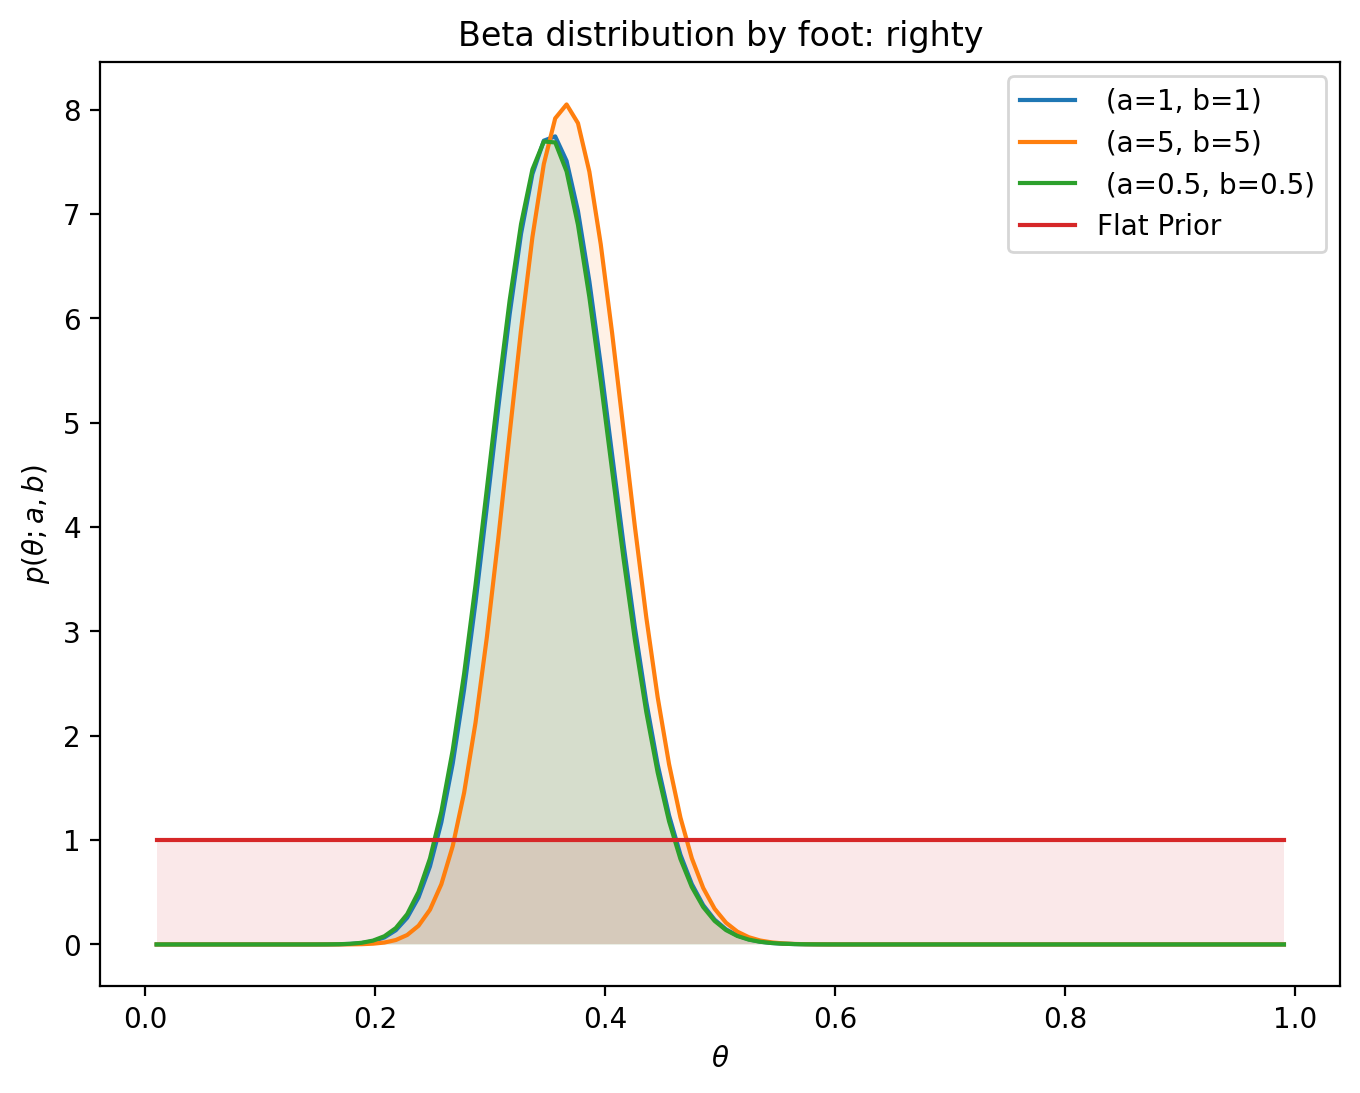

In [ ]:
# kick direction posterior for righty and lefty
d=2 # x2: KICK_DIRECTION
abs = [(1,1), (5, 5), (.5, .5)]
avals = [a[0] for a in abs]
bvals = [b[1] for b in abs]
showPostnoFilter(righty,d, 'foot: righty', avals, bvals)

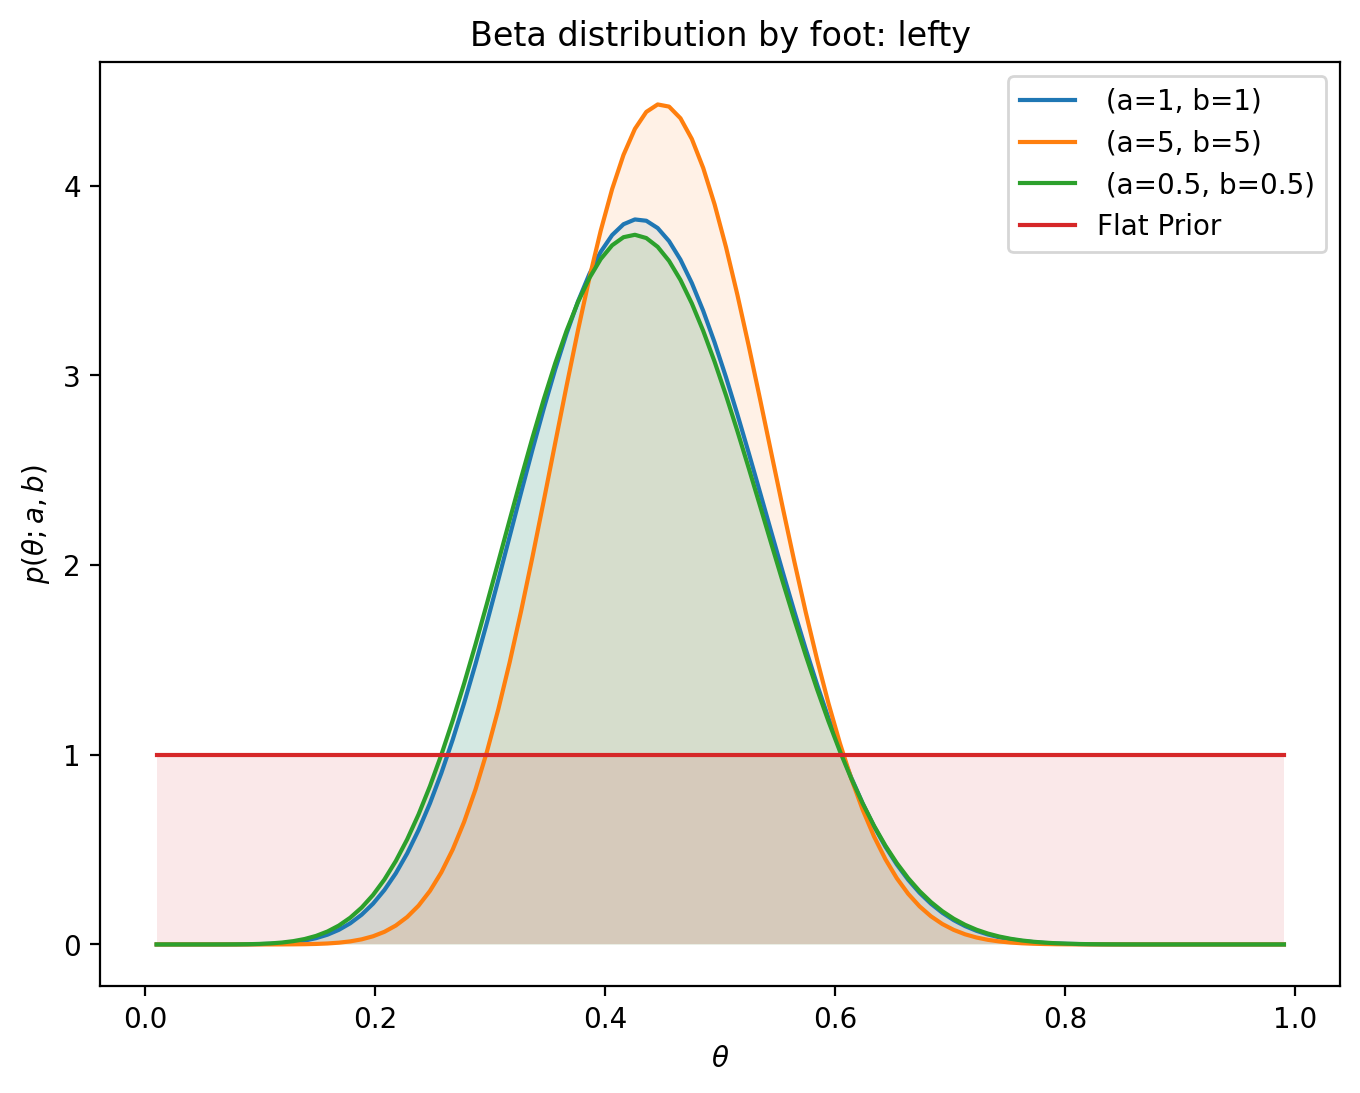

In [ ]:
showPostnoFilter(lefty,d, 'foot: lefty', avals, bvals)

1.3.4.2

Obtain the MAP estimations for the probability of kicking to the right in a penalty, for left and right-footed players, using flat prior.

In [ ]:
a = b = 1
d = 2
category = 'Kick_Direction'
item=1
X_1 = filter_data(data, category, item)
item=0
X_2 = filter_data(data, category, item)
theta1 = MAP_est(X_1,a,b)
theta2 = MAP_est(X_2,a,b)

In [ ]:
print(f"MAP estimate for right kick direction: {theta1}")
print(f"MAP estimate for left kick direction: {theta2}")

MAP estimate for right kick direction: [0.71794872 0.76923077 1.         0.46153846 0.53846154]
MAP estimate for left kick direction: [0.79104478 0.82089552 0.         0.50746269 0.64179104]


1.3.4.3

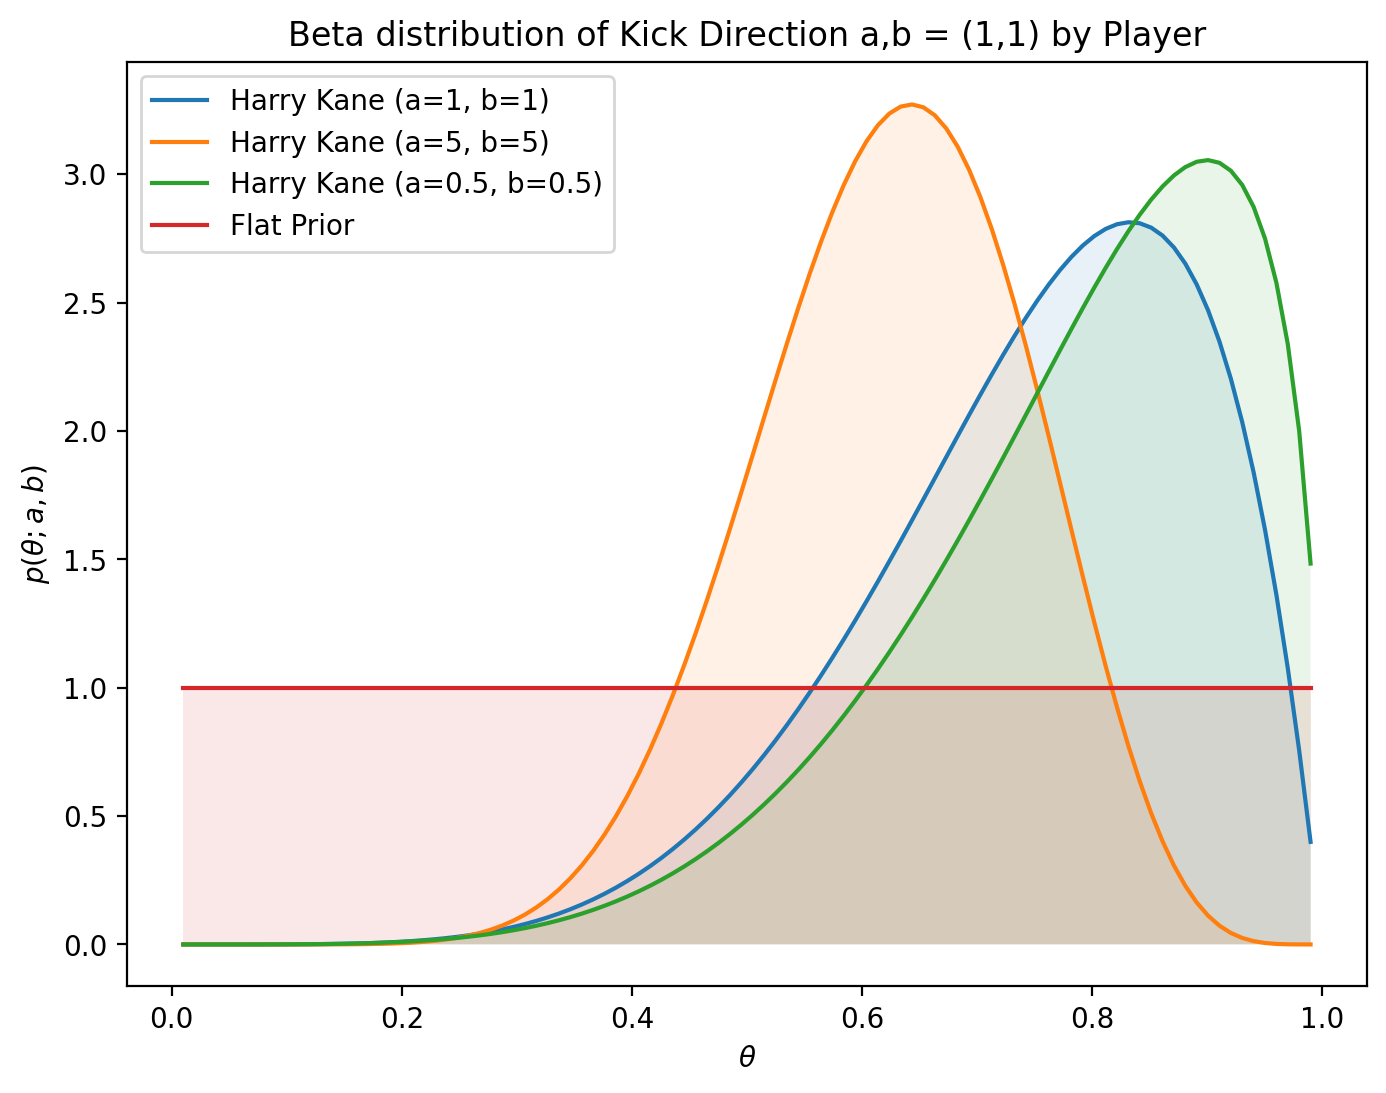

In [ ]:
# 1.3.4.3a
d=0
# in this case total=sole
showPost(d, ['Harry Kane'], 'Player',avals,bvals, d_cat=f'Kick Direction a,b = ({a},{b})', total_post=False)

In [ ]:
# 1.3.4.3b
for a,b in abs:
  print(f"MLE estimator for a = {a}, b = {b}: {ML_est(X,a,b)}")
  print(f"MAP estimator for a = {a}, b = {b}: {MAP_est(X,a,b)}")

MLE estimator for a = 1, b = 1: [0.76415094 0.80188679 0.36792453 0.49056604 0.60377358]
MAP estimator for a = 1, b = 1: [0.76415094 0.80188679 0.36792453 0.49056604 0.60377358]
MLE estimator for a = 5, b = 5: [0.76415094 0.80188679 0.36792453 0.49056604 0.60377358]
MAP estimator for a = 5, b = 5: [0.74561404 0.78070175 0.37719298 0.49122807 0.59649123]
MLE estimator for a = 0.5, b = 0.5: [0.76415094 0.80188679 0.36792453 0.49056604 0.60377358]
MAP estimator for a = 0.5, b = 0.5: [0.76666667 0.8047619  0.36666667 0.49047619 0.6047619 ]


### Questions

**1. Would you affirm that the prior strongly influence the posterior in the first case? (left/right footed players comparison)**

- Clearly, the influence of the parameters of the prior is stronger for left-footed players than for right-footed ones, the dissimilarity in the posteriors is visually larger for the left-footed players, this could be quantified simply using the KL divergence metric.

**2. If you were a goalkeeper, based on kick direction plot, which direction would you choose to dive, in case you do not know anything about the kicker? (Remember, $0 \equiv left, 1 \equiv right$)**.

- Right, because of the posteriors having slimmer tails.

**3. In the posterior for player Harry Kane, does the prior influence the posterior results more or less than in the previous case? Why?**

- Yes, in this case the influence of the prior is stronger than in previous cases. Harry Kane is a very versitle striker and his kick directions are varied, which is reflected in the dissimilarity of the posteriors for different parameters.

**4. Is there any case where MAP and ML estimations are the same? Why?**
- Trivially, when $a_d = b_d = 1$, the prior is flat and the formulas for the estimators are equivalent.

**5. Knowing that Harry Kane is one of the top scorers of the Premier League, which prior would you choose? .**

- A prior that concentrates most of the probability mass at the top.



# 2. Categorical data
In this seond section we use a model for categorical data. Each observation is one among $K$ categories. The parameter $\boldsymbol{\theta}$ is a vector with the probability of each obtaining each category. For this section, we are going to model the probability of musical genres appearing in the top50 year songs of Spotify.

## 2.1. Dataset


The number of total observations is $N=50$. In this case, $\theta$ is a vector, containing the probabilities for each genre. Observations are categorical, a number between 1 and $K=21$.

$x_i \in \{1, ..., K\}  \qquad \mathcal{D}= \{ x_1, ..., x_N \} \qquad $

We use a <a href="https://www.kaggle.com/leonardopena/top50spotify2019">dataset</a> with the top50 most listened songs of Spotify ing 2019. Data is formatted in file <code>top_spotify_2019.csv</code>, and we are going to model the categorical column <code>"Genre"</code> as $x_i \in \{1, ..., 21\}$.


In [ ]:
# If you run locally, set use_colab=False
use_colab=False

if use_colab==True:
    # To work in colab
    from google.colab import files
    uploaded = files.upload()
    import io
    data = pd.read_csv(io.BytesIO(uploaded['top_spotify_19.csv']), encoding='latin1')

else:
    data = pd.load_csvdata = pd.read_csv('top_spotify_19.csv', encoding='latin1')

Number of categories: 21


,Unnamed: 0,Track.Name,Artist.Name,Genre,Beats.Per.Minute,Energy,Danceability,Loudness..dB..,Liveness,Valence.,Length.,Acousticness..,Speechiness.,Popularity
0,1,Señorita,Shawn Mendes,canadian pop,117,55,76,-6,8,75,191,4,3,79
1,2,China,Anuel AA,reggaeton flow,105,81,79,-4,8,61,302,8,9,92
2,3,boyfriend (with Social House),Ariana Grande,dance pop,190,80,40,-4,16,70,186,12,46,85
3,4,Beautiful People (feat. Khalid),Ed Sheeran,pop,93,65,64,-8,8,55,198,12,19,86
4,5,Goodbyes (Feat. Young Thug),Post Malone,dfw rap,150,65,58,-4,11,18,175,45,7,94


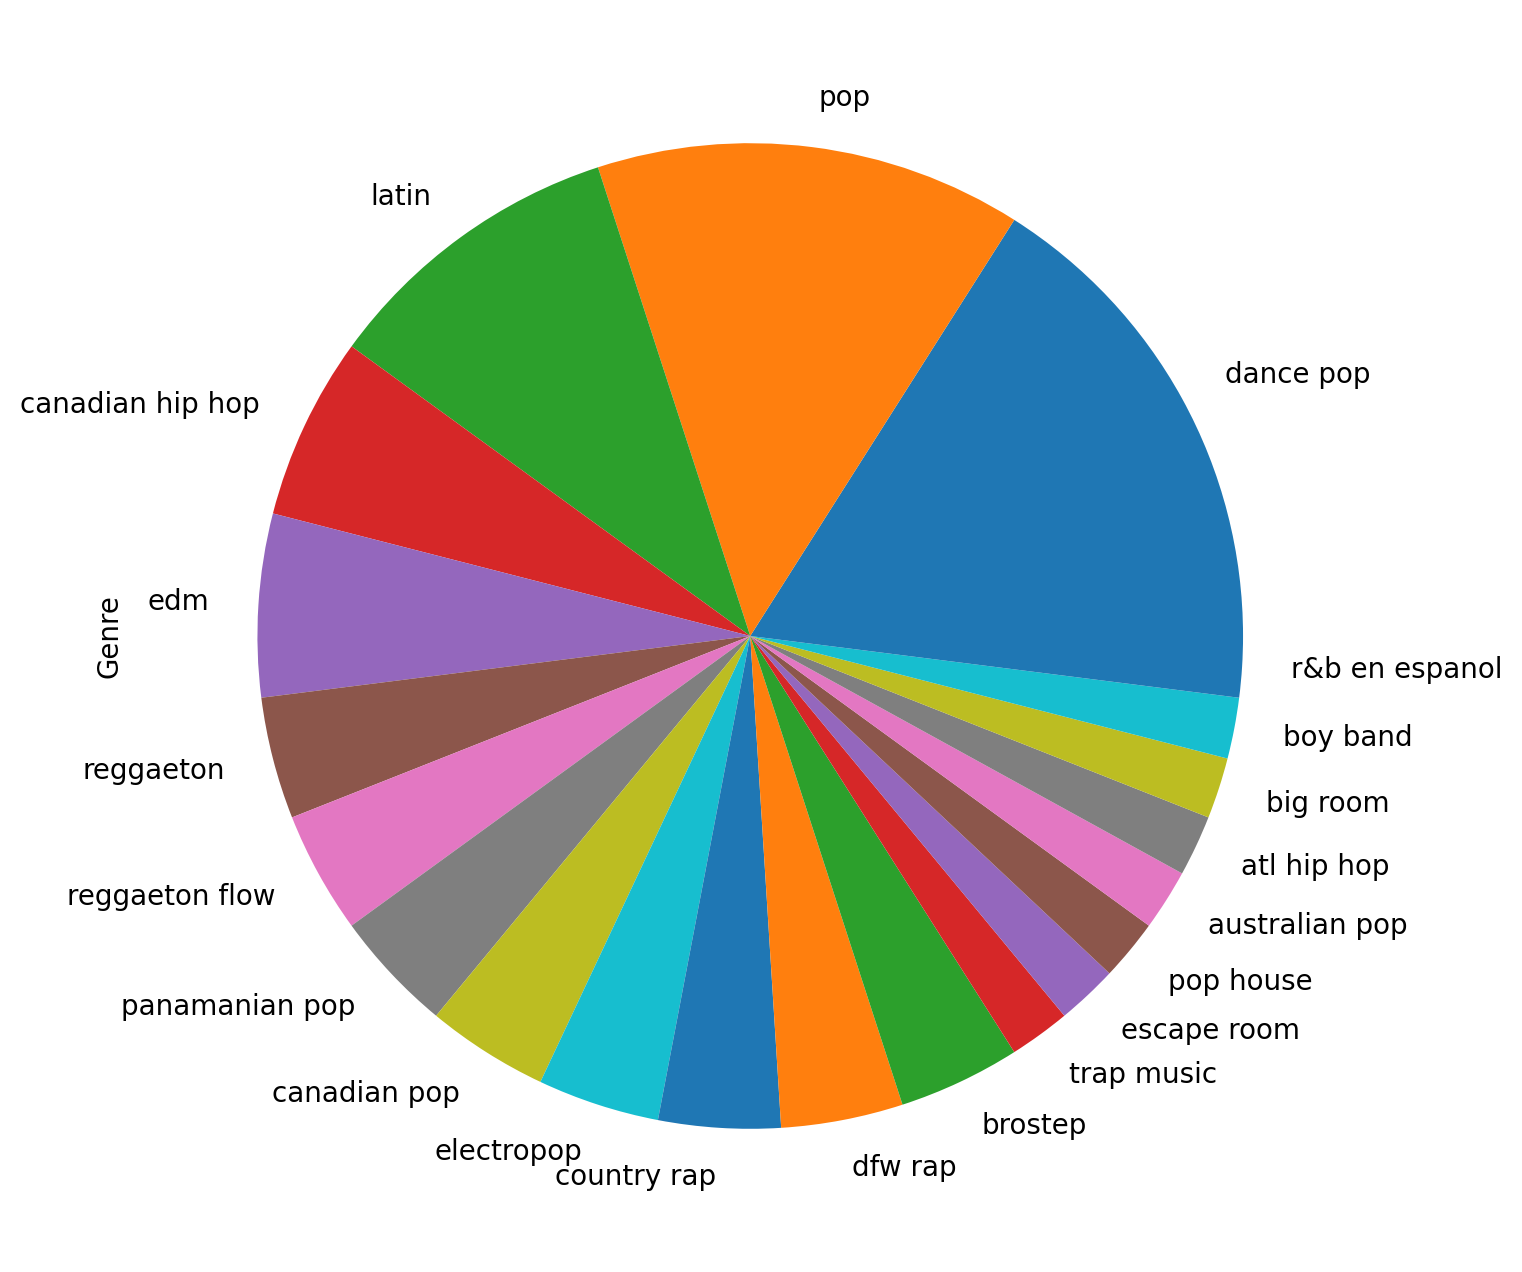

In [ ]:
N = len(data) # N=50

categories = data['Genre'].value_counts().keys().values
D = len(categories)
print("Number of categories: " + str(D))

data['Genre'].value_counts().plot.pie(figsize=(8, 8))
data.head()

## 2.2. Model

### 2.2.1. Likelihood
The likelihood is a **Multinomial distribution**, that models the probability of finding $N_k$ songs for each genre in the top50 list:

\begin{equation}
p(\mathcal{D} | \boldsymbol{\theta}) = \prod_{k=1}^K \theta_k^{N_k} \qquad N_k = \sum_{i=1}^N \mathbb{I} (x_i = k)
\end{equation}


### 2.2.2. Prior
We need a prior for modeling the probabilities $\theta_k$ for $k=\{1, ..., K \}$ that accomplishes $\sum_{k=1}^K\theta_k=1$. The values must sum $1$. This kind of distribution is called **Dirichlet distribution**, which confines the values of $\theta_k$ to a *simplex* of dimensionality $K-1$. The paramters of the distribution are $\alpha_k$ for $k=\{1, ..., K \}$, that defines the concentration of probability mass for each of the dimensions $k$. If $\alpha_k>1$ the mass tends to the center of the simplex in dimension $k$, while if $\alpha_k>1$ the mass tend to the corner. At last, for $\alpha_k=1$ the distribution is flat in the simplex.

\begin{equation}
p(\boldsymbol{\theta}) = \text{Dir}(\boldsymbol{\theta} | \boldsymbol{\alpha}) = \frac{1}{B(\boldsymbol{\alpha})} \prod_{k=1}^K \theta_k^{\alpha_k-1}
\end{equation}
where $B(\boldsymbol{\alpha}) = \frac{\prod_{k=1}^K \Gamma(\alpha_k)}{\Gamma (\alpha_0)}$ and $\alpha_0=\sum_{k=1}^K \alpha_k$.

An example for $K=3$ is included below. First row contains contours of the distribution $p(\boldsymbol{\theta})$, and second row includes samples from this distributions. In the first case (left), as $\alpha_k$ is nearly 1 but lower, the distribution is nearly uniform, and the mass is more concentrated in the corners, i. e. there are more samples in that locations of the simplex. In the second case (center), $\alpha_k>1$ and the probability mass is concentrated in the center. In the third case (right) an asymmetric example is included, the peak of probability is close to the first corner ($\alpha_1=2$) and far from the third corner ($\alpha_3=15$).



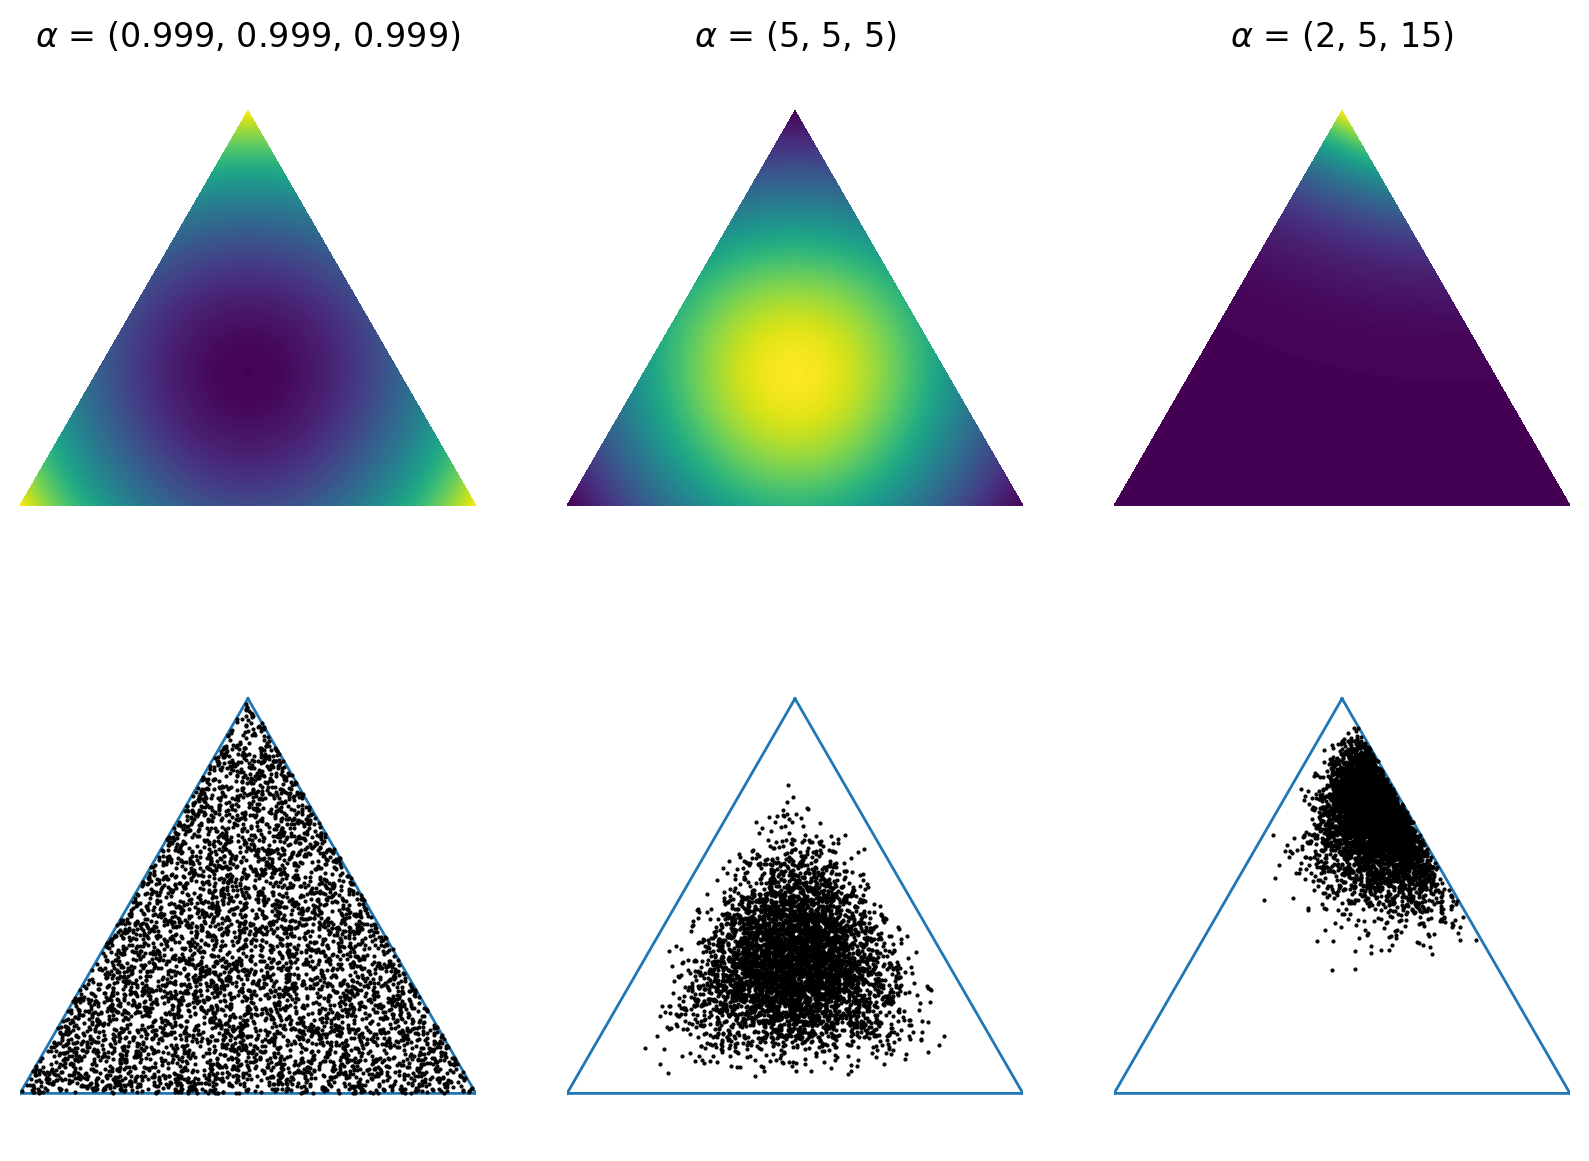

In [ ]:
'''Functions for drawing contours of Dirichlet distributions.'''

_corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
_AREA = 0.5 * 1 * 0.75**0.5
_triangle = tri.Triangulation(_corners[:, 0], _corners[:, 1])

# For each corner of the triangle, the pair of other corners
_pairs = [_corners[np.roll(range(3), -i)[1:]] for i in range(3)]
# The area of the triangle formed by point xy and another pair or points
tri_area = lambda xy, pair: 0.5 * np.linalg.norm(np.cross(*(pair - xy)))


def xy2bc(xy, tol=1.e-4):
    '''Converts 2D Cartesian coordinates to barycentric.
    Arguments:
        `xy`: A length-2 sequence containing the x and y value.
    '''
    coords = np.array([tri_area(xy, p) for p in _pairs]) / _AREA
    return softmax(coords)


def dirichlet_simplex(alpha, border=False, nlevels=200, subdiv=8, **kwargs):
    '''Draws pdf contours over an equilateral triangle (2-simplex).
    Arguments:
        `alpha`: Dirichlet parameter vector.
        `border` (bool): If True, the simplex border is drawn.
        `nlevels` (int): Number of contours to draw.
        `subdiv` (int): Number of recursive mesh subdivisions to create.
        kwargs: Keyword args passed on to `plt.triplot`.
    '''
    from matplotlib import ticker, cm
    import math

    refiner = tri.UniformTriRefiner(_triangle)
    trimesh = refiner.refine_triangulation(subdiv=subdiv)
    pvals = [dirichlet(alpha).pdf(xy2bc(xy)) for xy in zip(trimesh.x, trimesh.y)]

    plt.tricontourf(trimesh, pvals, nlevels, cmap='viridis', **kwargs)
    plt.axis('equal')
    plt.xlim(0, 1)
    plt.ylim(0, 0.75**0.5)
    plt.axis('off')
    if border is True:
        plt.triplot(_triangle, linewidth=1)


def plot_points(X, barycentric=True, border=True, **kwargs):
    '''Plots a set of points in the simplex.
    Arguments:
        `X` (ndarray): A 2xN array (if in Cartesian coords) or 3xN array
                       (if in barycentric coords) of points to plot.
        `barycentric` (bool): Indicates if `X` is in barycentric coords.
        `border` (bool): If True, the simplex border is drawn.
        kwargs: Keyword args passed on to `plt.plot`.
    '''
    if barycentric is True:
        X = X.dot(_corners)
    plt.plot(X[:, 0], X[:, 1], 'k.', ms=1, **kwargs)
    plt.axis('equal')
    plt.xlim(0, 1)
    plt.ylim(0, 0.75**0.5)
    plt.axis('off')
    if border is True:
        plt.triplot(_triangle, linewidth=1)


def plot_dirichlet(alphas):
    """Calls to pdf contour and sampling plots.
    `alphas`: LIST of Dirichlet parameter vectors.
    """
    plt.figure(figsize=(10, 7))
    for (i, alpha) in enumerate(alphas):
        plt.subplot(2, len(alphas), i + 1)
        title = r'$\alpha$ = ' + str(tuple(alpha))
        plt.title(title, fontdict={'fontsize': 12})
        dirichlet_simplex(alpha)
        plt.subplot(2, len(alphas), i + 1 + len(alphas))
        plot_points(dirichlet(alpha).rvs(5000))


alphas = [[0.999] * 3,
              [5] * 3,
              [2, 5, 15]]

# For plotting only one distribution:
#alpha=[[5, 5, 5]]

plot_dirichlet(alphas)



### 2.2.3. Posterior
The posterior distribution can be obtained from the prior and likelihood, using Bayes Rule:

\begin{gather}
\begin{matrix}
    p(\boldsymbol{\theta} | \mathcal{D}) &  \propto  & p(\mathcal{D} | \boldsymbol{\theta}) p(\boldsymbol{\theta}) \\
    & \propto & \prod_{k=1}^K \theta_k^{N_k} \theta_k^{\alpha_k-1} = \prod_{k=1}^K \theta_k^{N_k+\alpha_k-1}\\
    & = & \text{Dir}(\boldsymbol{\theta} | \textbf{N} + \boldsymbol{\alpha}) \\
\end{matrix}
\end{gather}
where $\textbf{N}=\{ N_1, ..., N_k\}$ and $N_k$ are the number of songs of genre $k$ in the $N=50$ spotify top list.

The posterior of $\boldsymbol{\theta}$, given the sufficient statistics from the observations in $\mathcal{D}$ and defining the prior as a Dirichlet, is another Dirichlet distribution with parameters $\textbf{N} + \boldsymbol{\alpha}$. This is another example of conjugate prior.

### 2.2.4. Estimation
In this example, the estimators have the following expressions:
- **Maximum A Posteriori (MAP)**:.
   
\begin{equation}
    \hat{\theta}_k^{MAP} = \frac{N_k+\alpha_k-1}{N+\alpha_0-K}
\end{equation}

- **Maximum Likelihood (ML)**:
   
\begin{equation}
    \hat{\theta}_{ML} = \underset{x}{\text{argmax}} p( \mathcal{D} | \theta) = \frac{N_1}{N}
\end{equation}

The **posterior predictive** that gives the probability of song $x$ from genre $k$ in a new top list is:
\begin{gather}
p(x=k | \mathcal{D}) = \frac{N_k+\alpha_k}{N+\alpha_0}
\end{gather}

## 2.3. Experiments

### 2.3.1. Computing the posterior distribution

Compute the $\boldsymbol{\alpha}$ parameters of the posterior distribution. Use a flat prior.


In [ ]:
#############
#           #
# YOUR CODE #
#           #
#############

genre_counts = data['Genre'].value_counts()

# Define the flat prior (all alpha_k set to 1)
alpha_prior = np.ones(len(genre_counts))

# Compute the posterior parameters
alpha_posterior = genre_counts.values + alpha_prior

print("Posterior Parameters (alpha_posterior):")
print(alpha_posterior)


Posterior Parameters (alpha_posterior):
[9. 8. 6. 4. 4. 3. 3. 3. 3. 3. 3. 3. 3. 2. 2. 2. 2. 2. 2. 2. 2.]


### 2.3.2. Parameter estimation

Obtain the MAP estimator for parameters $\hat{\theta}_k$ for all the genres. Plot a pie chart with this probabilities, using <code>pd.Series(data=theta_map, index=categories, name='MAP estimates').plot.pie()</code>.


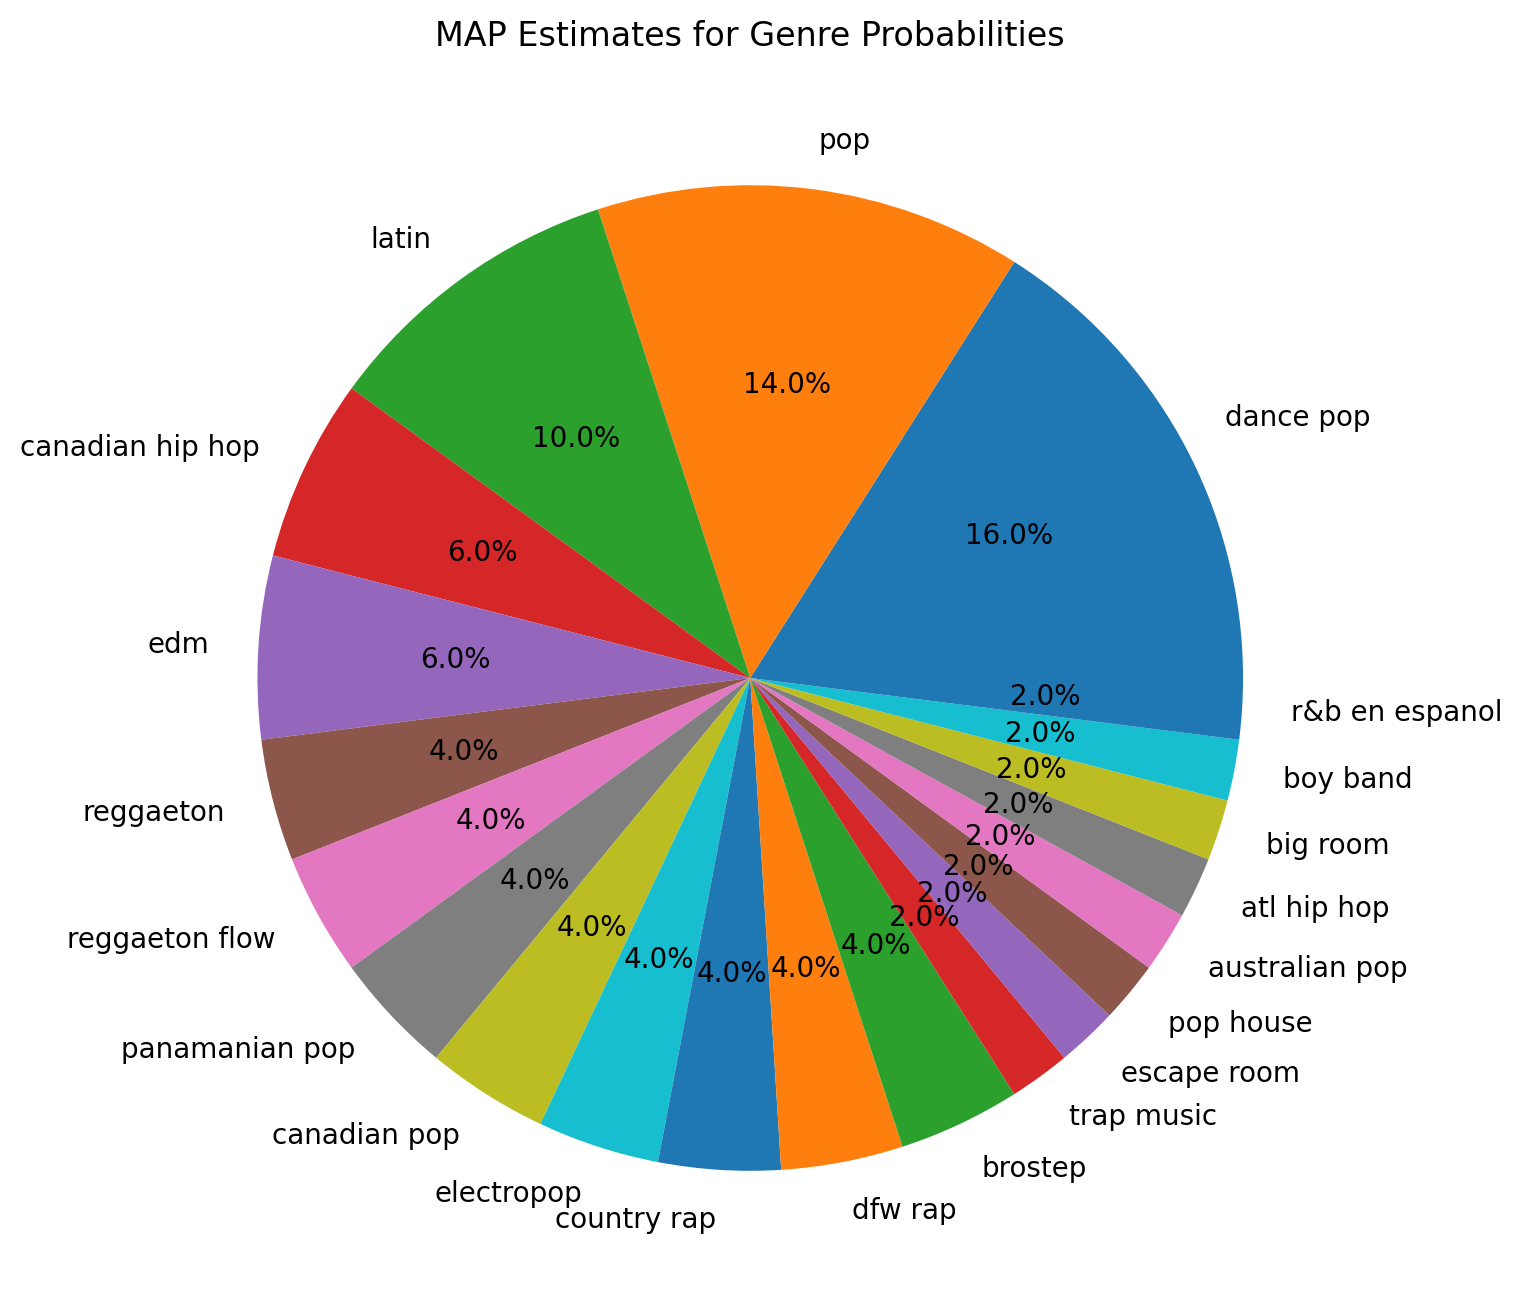

In [ ]:
import random
random.seed(42)

def dirichlet_MAP_est(Nk, N, alpha):
    """MAP estimation of theta, given counts Nk, trials N and Dirichlet prior parameters alpha"""
    #############
    #           #
    # YOUR CODE #
    #           #
    #############

    alpha0 = np.sum(alpha)
    theta = (Nk + alpha - 1) / (N + alpha0 - 1)

    return theta

#############
#           #
# YOUR CODE #
#           #
#############

theta_map = {}

# Calculate the MAP estimates for each genre
for genre, count in genre_counts.items():
    Nk = count
    alphak = 1  # Alpha parameter for the flat prior
    theta_map[genre] = dirichlet_MAP_est(Nk, N, alphak)

# Create a pandas Series for the pie chart
theta_series = pd.Series(data=theta_map, index = categories, name='MAP estimates')

# Plot a pie chart
theta_series.plot.pie(autopct='%1.1f%%', figsize=(8, 8))
plt.title('MAP Estimates for Genre Probabilities')
plt.ylabel('')
plt.show()





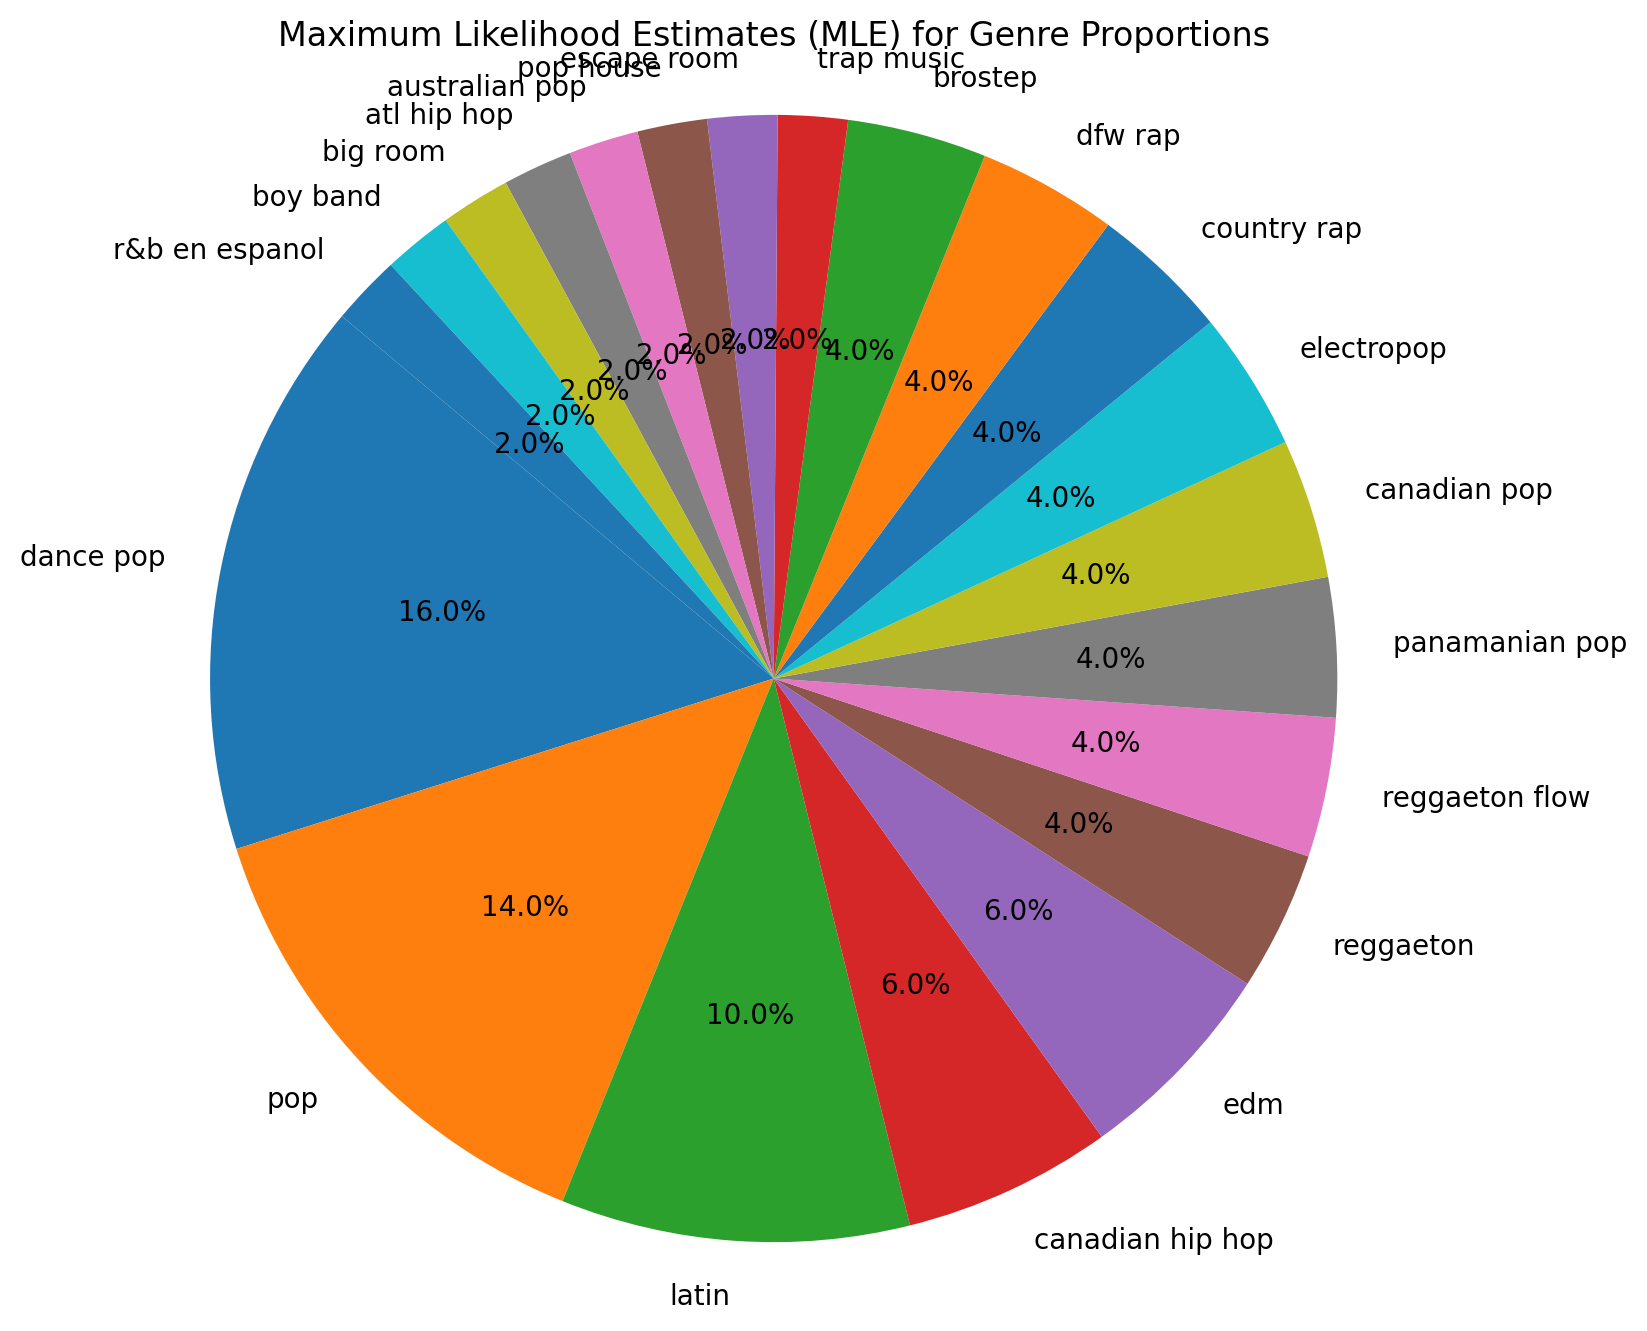

In [ ]:
# Count the number of songs in each genre (Maximum Likelihood Estimates)
genre_counts = data['Genre'].value_counts()

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(genre_counts, labels=genre_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Maximum Likelihood Estimates (MLE) for Genre Proportions')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

## Questions

**1. Which is the probability that in year 2020, and given 2019 data, a "dance pop" song appear in the top50 of Spotify?**.

- The probability of a 'dance pop' song appearing on 2020 Top 50 songs of Spotify is a 16%. This is explained since a flat prior allows an equivalence from the two previous charts, which is translated into a probability equal to the proportions obtained in visualization from 2019 data (the MLE graph shown above may help visualizing the answer)

**2. Would you appreciate big differences between pie chart of genre proportions and MAP estimations? Why? *Hint: first pie is equivalent to another estimator*.**

- No, there is no difference between the two charts. The reasoning is that infering a posterior distribution using the information obtained from the data given using a flat (constant) prior, and while MAP estimator is obtained by both ML and prior distribution, then the MAP distribution is equal to the ML distribution, or in other words, to the given data proportions

Note: notice that the MLE distribution is obtained from the likelihood while MAP is obtained from both the likelihood and the prior (flat)

## References

[1]. Murphy, K. P. (2012). Machine learning: a probabilistic perspective. MIT press.

[2]. Bishop, C. M. (2006). Pattern recognition and machine learning. springer.

